In [1]:
pip install python-dotenv psycopg2

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install sqlalchemy==2.0

Note: you may need to restart the kernel to use updated packages.


 **1. Для начала импортируем все библиотеки, которые могут понадобиться**

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import sqlite3
import requests
import sqlalchemy
from typing import List, Optional
from sqlalchemy import Column, String, Text, ForeignKey, func, exists
from sqlalchemy.orm import declarative_base, sessionmaker, relationship
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

**2. Подключаемся к supabase**

In [5]:
USER = 'postgres.cwjwifniusnhiltixqff'
PASSWORD = 'n19ht15DGN$'
HOST = 'aws-1-eu-central-1.pooler.supabase.com'
PORT = '6543'
DBNAME = 'postgres'

DATABASE_URL = f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}?sslmode=require"

In [6]:
engine = sqlalchemy.create_engine(DATABASE_URL)

In [7]:
os.getcwd()

'/Users/oksanatebieva/Downloads'

In [8]:
sqlite_connector = sqlite3.connect('test.db')

**3. Создаем подключение к API Всемирного банка**

In [9]:
url = 'https://api.worldbank.org/v2/country'  # endpoint (API метод) для получения стран

params = {
            'format': 'json',  # Формат JSON
            'per_page': 296  # Количество записей на странице (296 стран всего)
}

In [10]:
response = requests.get(url, params=params)  # Получаем данные с endpoint
data = response.json()  # Ответ конвертируем в JSON

In [11]:
data[0]

{'page': 1, 'pages': 1, 'per_page': '296', 'total': 296}

In [12]:
data[1][0]

{'id': 'ABW',
 'iso2Code': 'AW',
 'name': 'Aruba',
 'region': {'id': 'LCN',
  'iso2code': 'ZJ',
  'value': 'Latin America & Caribbean '},
 'adminregion': {'id': '', 'iso2code': '', 'value': ''},
 'incomeLevel': {'id': 'HIC', 'iso2code': 'XD', 'value': 'High income'},
 'lendingType': {'id': 'LNX', 'iso2code': 'XX', 'value': 'Not classified'},
 'capitalCity': 'Oranjestad',
 'longitude': '-70.0167',
 'latitude': '12.5167'}

In [13]:
countries = data[1]

**4. Создаем датафреймы, вытаскиваем словари из JSON**

In [14]:
pd.DataFrame(countries).sample(3)

,id,iso2Code,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
206,NXS,6N,IDA countries not classified as fragile situat...,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
232,SAS,8S,South Asia,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
35,BRA,BR,Brazil,"{'id': 'LCN', 'iso2code': 'ZJ', 'value': 'Lati...","{'id': 'LAC', 'iso2code': 'XJ', 'value': 'Lati...","{'id': 'UMC', 'iso2code': 'XT', 'value': 'Uppe...","{'id': 'IBD', 'iso2code': 'XF', 'value': 'IBRD'}",Brasilia,-47.9292,-15.7801


In [15]:
temp_df = pd.json_normalize(countries)

In [16]:
temp_df.head(5)

,id,iso2Code,name,capitalCity,longitude,latitude,region.id,region.iso2code,region.value,adminregion.id,adminregion.iso2code,adminregion.value,incomeLevel.id,incomeLevel.iso2code,incomeLevel.value,lendingType.id,lendingType.iso2code,lendingType.value
0,ABW,AW,Aruba,Oranjestad,-70.0167,12.5167,LCN,ZJ,Latin America & Caribbean,,,,HIC,XD,High income,LNX,XX,Not classified
1,AFE,ZH,Africa Eastern and Southern,,,,NA,NA,Aggregates,,,,NA,NA,Aggregates,,,Aggregates
2,AFG,AF,Afghanistan,Kabul,69.1761,34.5228,MEA,ZQ,"Middle East, North Africa, Afghanistan & Pakistan",MNA,XQ,"Middle East, North Africa, Afghanistan & Pakis...",LIC,XM,Low income,IDX,XI,IDA
3,AFR,A9,Africa,,,,NA,NA,Aggregates,,,,NA,NA,Aggregates,,,Aggregates
4,AFW,ZI,Africa Western and Central,,,,NA,NA,Aggregates,,,,NA,NA,Aggregates,,,Aggregates


In [17]:
temp_df.to_csv('temp_df.csv', encoding='utf-8') # сохраняем файл

In [18]:
def fetch_worldbank_data(indicators: List[str],
                         countries: List[str],
                         start_year: int,
                         end_year: int,
                         language: str = 'en') -> pd.DataFrame:

    '''
    Получает данные показателей из API Всемирного банка.

    Args:
        indicators: Список кодов показателей (например, ['EN.GHG.CO2.IC.MT.CE.AR5'])
        countries: Список кодов стран в формате ISO 2 или ISO 3 (например, ['RU', 'US'])
        start_year: Год начала периода
        end_year: Год окончания периода
        language: Язык данных ('en', 'ru' и т.д.)

    Returns:
        pandas.DataFrame с данными показателей
    '''

    base_url = "https://api.worldbank.org/v2" # endpoint API - адрес по которому мы обращаемся за данными

    # преобразовываем страны в строку с разделителем точка с запятой (для запроса данных)
    countries_str = ';'.join(countries)

    # список для хранения данных о показателях
    all_data = []

    try:
        for indicator in indicators:
            # Формируем URL для запроса
            url = f"{base_url}/{language}/country/{countries_str}/indicator/{indicator}"
            params = {
                'format': 'json',
                'date': f"{start_year}:{end_year}",
                'per_page': 10000  # Большое значение для получения всех данных
            }

            # Выполняем запрос к API
            response = requests.get(url, params=params)
            response.raise_for_status()

            data = response.json()

            # API возвращает массив, где первый элемент - метаданные, второй - данные
            if len(data) > 1 and isinstance(data[1], list):
                for item in data[1]:
                    if item.get('value') is not None:
                        all_data.append({
                            'country': item['country']['value'],
                            'country_code': item['countryiso3code'],
                            'indicator': item['indicator']['value'],
                            'indicator_code': item['indicator']['id'],
                            'year': int(item['date']),
                            'value': item['value']
                        })

        # Создаем DataFrame
        df = pd.DataFrame(all_data)

        if df.empty:
            print("Предупреждение: Не получено данных для указанных параметров")
            return df

        return df

    # Обрабатываем возможные ошибки при работе с АПИ
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе к API: {e}")
        return pd.DataFrame()
    except (KeyError, IndexError, ValueError) as e:
        print(f"Ошибка при обработке данных: {e}")
        return pd.DataFrame()

In [19]:
def get_countries(
        url: str='https://api.worldbank.org/v2/country', 
        params: dict={'format': 'json', 'per_page': 296}
        ) -> pd.DataFrame:
    
    # проверяем на наличие переданных параметров в функцию
    if params is not None:
        response = requests.get(url, params=params)

    else:
        # если параметры не переданы, используем только endpoint
        response = requests.get(url)
    
    # переделываем ответ в JSON
    data = response.json()

    # нормализуем JSON в датафрейм pandas
    countries = pd.json_normalize(data[1])

    # обрабатываем столбцы: чтобы привести их к snake_case необходимо заменить
    # точки и заглавные буква на нижнее подчеркивание (в принципе - это хардкод,
    # но данные всемирного банка вряд ли будут меняться, поэтому можно)
    countries.columns = (
        countries.columns.str.replace('.', '_')
        .str.replace('C', '_c')
        .str.replace('L', '_l')
        .str.replace('T', '_t')
        )

    # убираем агрегированные регионы (например, африка или юго-восточная азия)
    countries = countries[countries['lending_type_value'] != 'Aggregates']

    return countries

In [20]:
countries_df = get_countries()
countries_df.head(5)

,id,iso2_code,name,capital_city,longitude,latitude,region_id,region_iso2code,region_value,adminregion_id,adminregion_iso2code,adminregion_value,income_level_id,income_level_iso2code,income_level_value,lending_type_id,lending_type_iso2code,lending_type_value
0,ABW,AW,Aruba,Oranjestad,-70.0167,12.5167,LCN,ZJ,Latin America & Caribbean,,,,HIC,XD,High income,LNX,XX,Not classified
2,AFG,AF,Afghanistan,Kabul,69.1761,34.5228,MEA,ZQ,"Middle East, North Africa, Afghanistan & Pakistan",MNA,XQ,"Middle East, North Africa, Afghanistan & Pakis...",LIC,XM,Low income,IDX,XI,IDA
5,AGO,AO,Angola,Luanda,13.242,-8.81155,SSF,ZG,Sub-Saharan Africa,SSA,ZF,Sub-Saharan Africa (excluding high income),LMC,XN,Lower middle income,IBD,XF,IBRD
6,ALB,AL,Albania,Tirane,19.8172,41.3317,ECS,Z7,Europe & Central Asia,ECA,7E,Europe & Central Asia (excluding high income),UMC,XT,Upper middle income,IBD,XF,IBRD
7,AND,AD,Andorra,Andorra la Vella,1.5218,42.5075,ECS,Z7,Europe & Central Asia,,,,HIC,XD,High income,LNX,XX,Not classified


In [21]:
countries_df.to_csv('countries_df.csv', encoding='utf-8')

In [22]:
# Получаем данные по выбросам CO2 для РФ, США, Китая и Японии за 2015-2024 год
indicators = ['EN.GHG.CO2.IC.MT.CE.AR5']  # Промышленные выбросы CO2
countries = ['RU', 'US', 'CN', 'JP']  # Россия, США, Китай, Япония
start_year = 2015
end_year = 2024

indicators_df = fetch_worldbank_data(indicators, countries, start_year, end_year)

indicators_df.to_csv('indicators_df.csv', encoding='utf-8')
indicators_df.head(6)

,country,country_code,indicator,indicator_code,year,value
0,China,CHN,Carbon dioxide (CO2) emissions from Industrial...,EN.GHG.CO2.IC.MT.CE.AR5,2024,2793.0196
1,China,CHN,Carbon dioxide (CO2) emissions from Industrial...,EN.GHG.CO2.IC.MT.CE.AR5,2023,2739.3157
2,China,CHN,Carbon dioxide (CO2) emissions from Industrial...,EN.GHG.CO2.IC.MT.CE.AR5,2022,2710.3206
3,China,CHN,Carbon dioxide (CO2) emissions from Industrial...,EN.GHG.CO2.IC.MT.CE.AR5,2021,2758.9483
4,China,CHN,Carbon dioxide (CO2) emissions from Industrial...,EN.GHG.CO2.IC.MT.CE.AR5,2020,2804.1148
5,China,CHN,Carbon dioxide (CO2) emissions from Industrial...,EN.GHG.CO2.IC.MT.CE.AR5,2019,2761.0671


In [23]:
# Получаем данные по численности населения для РФ, США, Китая и Японии за 2015-2024 год
indicators_pop = ['SP.POP.TOTL']
countries = ['RU', 'US', 'CN', 'JP']
start_year = 2015
end_year = 2024

indicators_pop = fetch_worldbank_data(indicators_pop, countries, start_year, end_year)

indicators_pop.to_csv('indicators_pop.csv', encoding='utf-8')
indicators_pop.head(6)

,country,country_code,indicator,indicator_code,year,value
0,China,CHN,"Population, total",SP.POP.TOTL,2024,1408975000
1,China,CHN,"Population, total",SP.POP.TOTL,2023,1410710000
2,China,CHN,"Population, total",SP.POP.TOTL,2022,1412175000
3,China,CHN,"Population, total",SP.POP.TOTL,2021,1412360000
4,China,CHN,"Population, total",SP.POP.TOTL,2020,1411100000
5,China,CHN,"Population, total",SP.POP.TOTL,2019,1407745000


**Посмотрим распределение стран по уровню дохода**

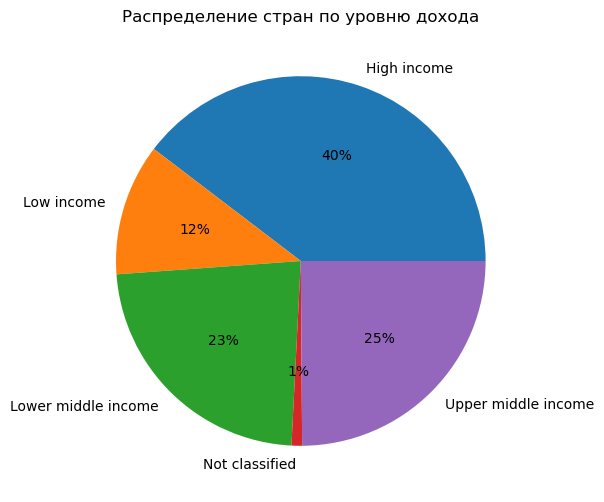

In [24]:
s = (
    temp_df.loc[temp_df['incomeLevel.value'] != "Aggregates"]     
             .groupby('incomeLevel.value')
             .size()
)

ax = s.plot(kind='pie', autopct='%1.0f%%', figsize=(6, 6), legend=False)
ax.set(ylabel=None)
plt.title('Распределение стран по уровню дохода')
plt.show()

40% стран имеют высокий показатель входящих средств, кажется, очень высокий показатель

**Посмотрим, в какой стране был самый высокий выброс СО2 в 2024 году**

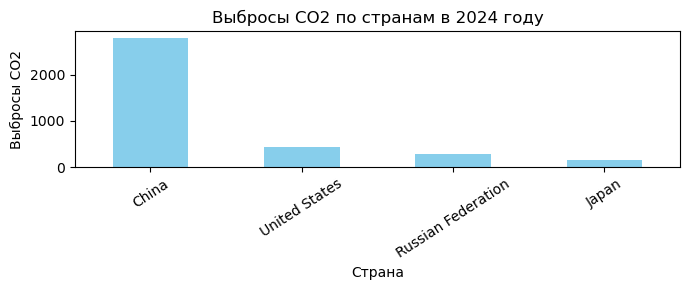

In [25]:
# Берём данные только за 2024 год
data_2024 = indicators_df[indicators_df['year'] == 2024]

# Суммируем выбросы по странам
country_2024 = (
    data_2024
    .groupby('country')['value']
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(7, 3))
country_2024.plot(kind='bar', color='skyblue')

plt.title('Выбросы CO2 по странам в 2024 году')
plt.ylabel('Выбросы CO2')
plt.xlabel('Страна')
plt.xticks(rotation=33)
plt.tight_layout()
plt.show()

Китай уверенно лидирует по выбросам углекислого газа

**А теперь сравним численность населения по странам и годам**

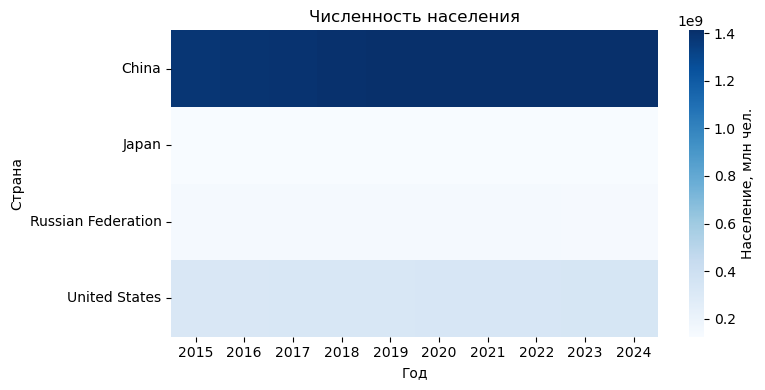

In [26]:
# Делаем сводную таблицу: строки — годы, столбцы — страны, значения — население
pop_pivot = (
    indicators_pop
    .pivot(index='year', columns='country', values='value')
    .sort_index()
)

plt.figure(figsize=(8, 4))
sns.heatmap(pop_pivot.T, annot=False, fmt='.0f', cmap='Blues', cbar_kws={'label': 'Население, млн чел.'})
plt.title('Численность населения')
plt.xlabel('Год')
plt.ylabel('Страна')
plt.tight_layout()
plt.show()